In [1]:
import sys
import json
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.sparse as scsp
import seaborn as sns
from collections import Counter
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import spacy

from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary

from ast import literal_eval

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer

from sentence_transformers import SentenceTransformer

from dictances import bhattacharyya

/Server/python/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the databases
df_calls_horizon = pd.read_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/dataset/horizon_topics.parquet')
df_calls_eic = pd.read_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/dataset/eic_topics.parquet')
df_publications = pd.read_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/dataset/publications_topics.parquet')

# 1. Calculate embeddings

## 1.1. Using word2vec

In [3]:
def get_embeddings(text, model):
    '''
    Function for obtaining the embeddings of a text
    
    text -> Text which we want to obtain embeddings
    model -> word2vec model for obtaining embeddings
    '''
    
    tokens = word_tokenize(text)
    embeddings = [model.wv[token] for token in tokens if token in model.wv]
    if embeddings:
        return sum(embeddings) / len(embeddings)
    else:
        return [0] * model.vector_size

### 1.1.1. Analysis

In [4]:
# Tokenize all the textual columns of our databases
tokenized_publications = [word_tokenize(text) for text in df_publications['raw_text']]

tokenized_calls_horizon_scope = [word_tokenize(text) for text in df_calls_horizon['Scope_raw_text']]
tokenized_calls_horizon_outcome = [word_tokenize(text) for text in df_calls_horizon['Expected Outcome_raw_text']]

tokenized_calls_eic_background_and_scope = [word_tokenize(text) for text in df_calls_eic['Background and Scope_raw_text']]
tokenized_calls_eic_goal = [word_tokenize(text) for text in df_calls_eic['Overall Goal & Specific Objectives_raw_text']]
tokenized_calls_eic_outcomes = [word_tokenize(text) for text in df_calls_eic['Expected Outcomes & Impacts_raw_text']]

In [6]:
# train the model
model = Word2Vec(tokenized_publications + tokenized_calls_horizon_scope + tokenized_calls_horizon_outcome + tokenized_calls_eic_background_and_scope + tokenized_calls_eic_goal + tokenized_calls_eic_outcomes, 
                 vector_size=100, window=5, min_count=1, workers=4)

In [7]:
# obtain embeddings
df_publications['embeddings'] = df_publications['raw_text'].apply(lambda x: get_embeddings(x, model))

df_calls_horizon['scope_embeddings'] = df_calls_horizon['Scope_raw_text'].apply(lambda x: get_embeddings(x, model))
df_calls_horizon['outcome_embeddings'] = df_calls_horizon['Expected Outcome_raw_text'].apply(lambda x: get_embeddings(x, model))

df_calls_eic['scope_embeddings'] = df_calls_eic['Background and Scope_raw_text'].apply(lambda x: get_embeddings(x, model))
df_calls_eic['goal_embeddings'] = df_calls_eic['Overall Goal & Specific Objectives_raw_text'].apply(lambda x: get_embeddings(x, model))
df_calls_eic['impacts_embeddings'] = df_calls_eic['Expected Outcomes & Impacts_raw_text'].apply(lambda x: get_embeddings(x, model))

#### 1.1.1.1 Token Exploration

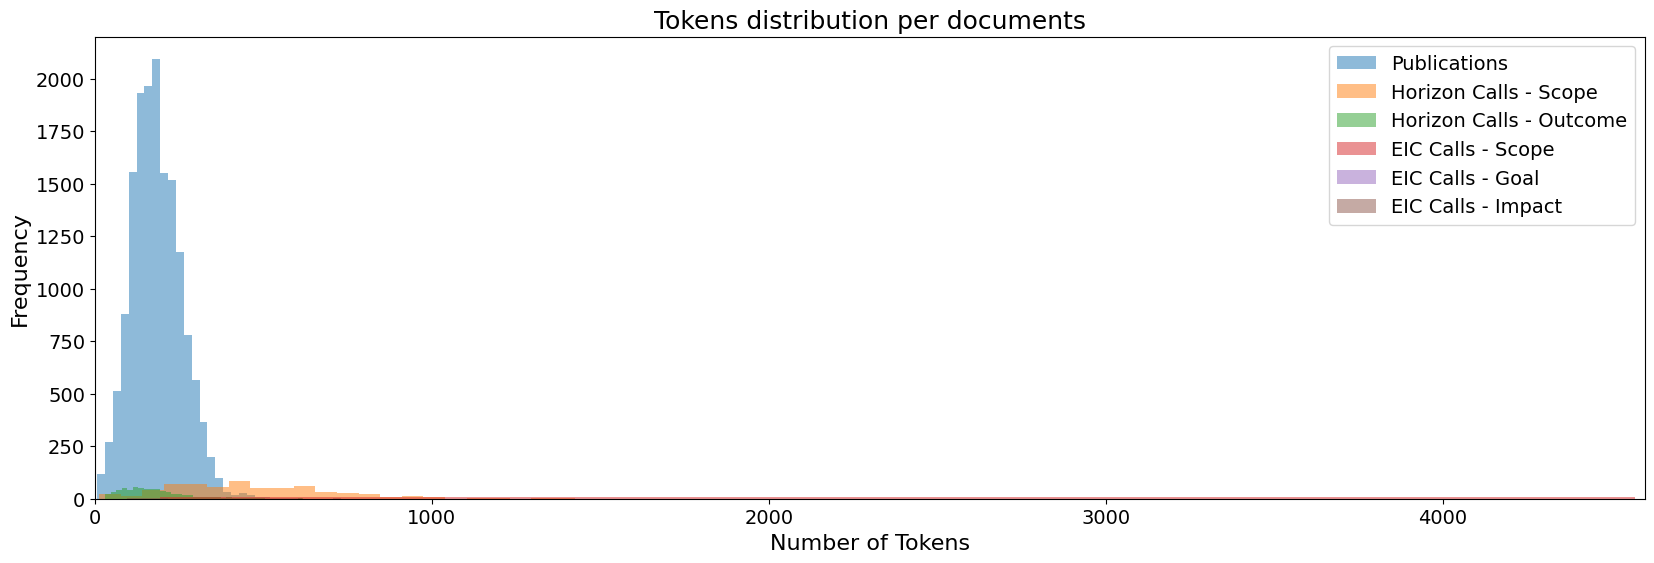

In [17]:
# Get number of tokens per doc
lengths_publications = [len(tokens) for tokens in tokenized_publications]

lengths_calls_scope = [len(tokens) for tokens in tokenized_calls_horizon_scope]
lengths_calls_outcome = [len(tokens) for tokens in tokenized_calls_horizon_outcome]

lengths_calls_eic_scope = [len(tokens) for tokens in tokenized_calls_eic_background_and_scope]
lengths_calls_eic_goal = [len(tokens) for tokens in tokenized_calls_eic_goal]
lengths_calls_eic_impact= [len(tokens) for tokens in tokenized_calls_eic_outcomes]

# Create an overlapping histogram
plt.figure(figsize=(20, 6))
plt.xlim(0, 4600)  
plt.ylim(0, 2200) 

plt.hist(lengths_publications, bins=50, alpha=0.5, label='Publications')

plt.hist(lengths_calls_scope, bins=50, alpha=0.5, label='Horizon Calls - Scope')
plt.hist(lengths_calls_outcome, bins=50, alpha=0.5, label='Horizon Calls - Outcome')

plt.hist(lengths_calls_eic_scope, bins=50, alpha=0.5, label='EIC Calls - Scope')
plt.hist(lengths_calls_eic_goal, bins=50, alpha=0.5, label='EIC Calls - Goal')
plt.hist(lengths_calls_eic_impact, bins=50, alpha=0.5, label='EIC Calls - Impact')


plt.title('Tokens distribution per documents', fontsize=18)
plt.xlabel('Number of Tokens', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend()
plt.legend(fontsize=14)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)  
plt.show()


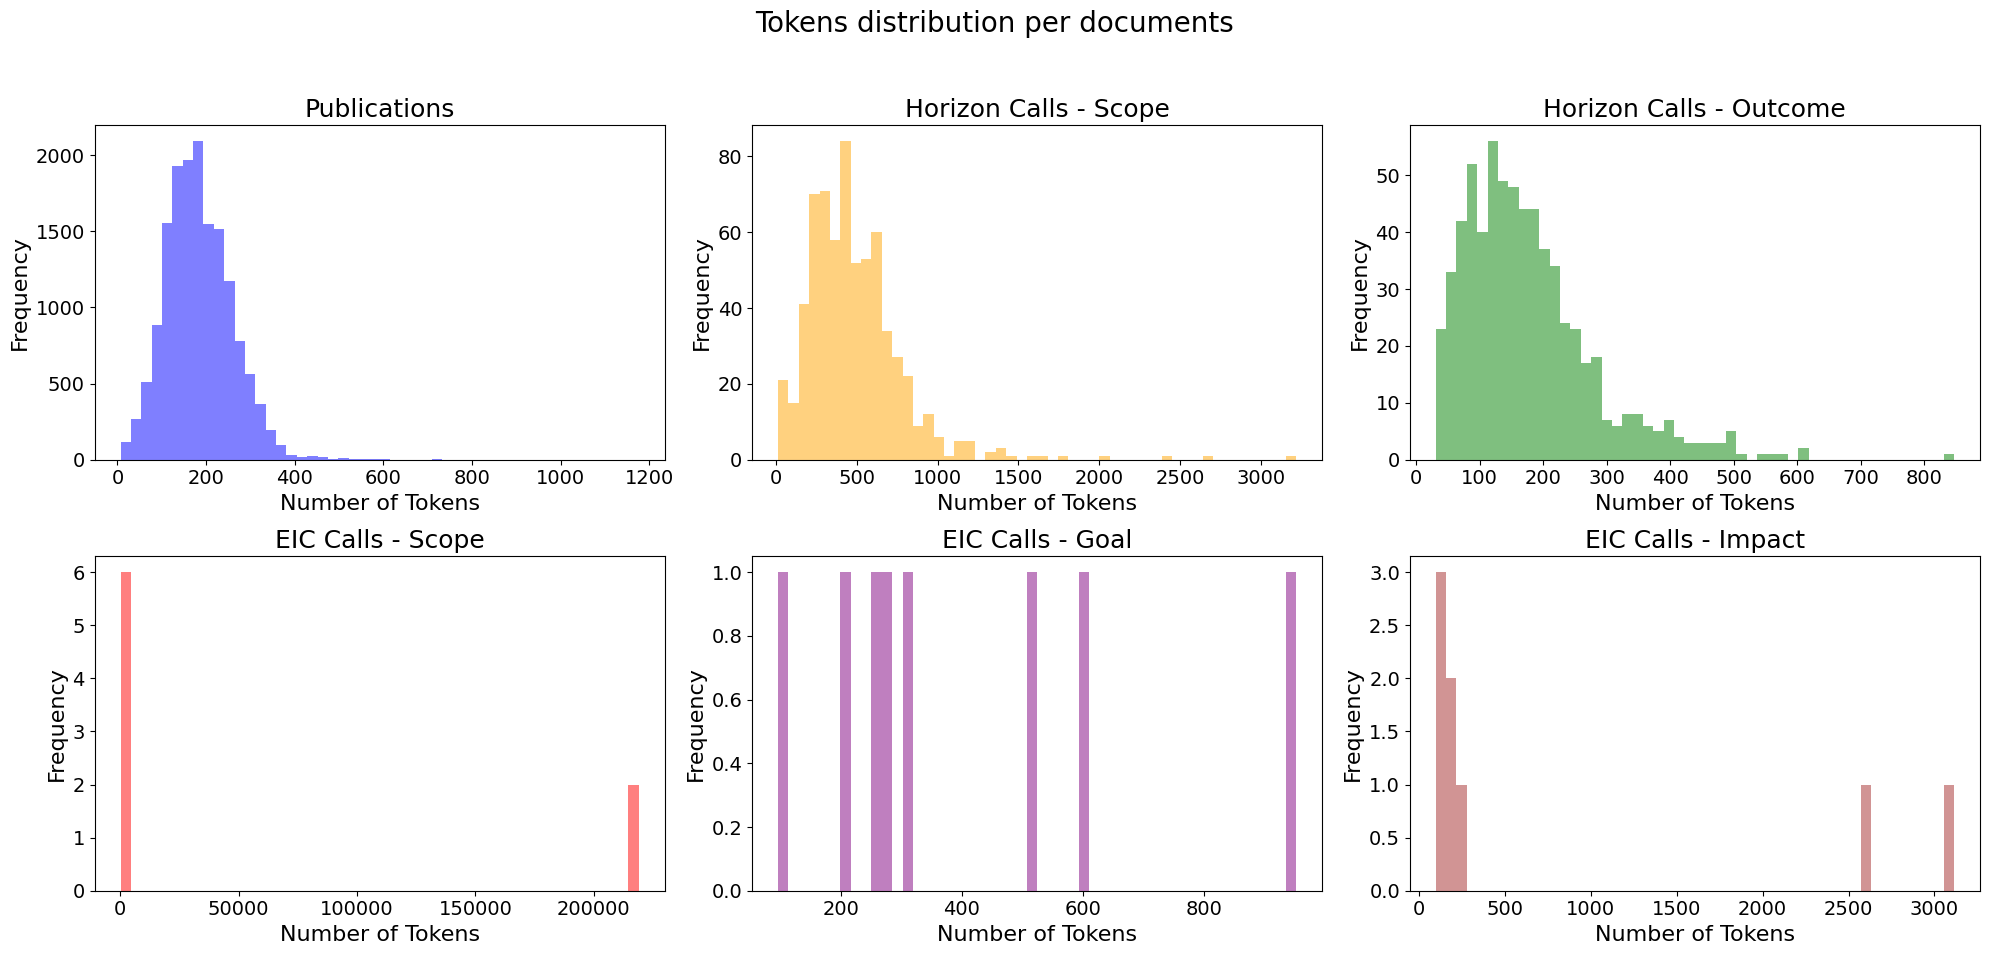

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Tokens distribution per documents', fontsize=20)

columns = ['Publications', 'Horizon Calls - Scope', 'Horizon Calls - Outcome',
           'EIC Calls - Scope', 'EIC Calls - Goal', 'EIC Calls - Impact']
lengths = [lengths_publications, lengths_calls_scope, lengths_calls_outcome,
           lengths_calls_eic_scope, lengths_calls_eic_goal, lengths_calls_eic_impact]

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

for i, ax in enumerate(axs.flatten()):
    ax.hist(lengths[i], bins=50, alpha=0.5, label=columns[i], color=colors[i])
    ax.set_title(columns[i], fontsize=18)
    ax.set_xlabel('Number of Tokens', fontsize=16)
    ax.set_ylabel('Frequency', fontsize=16)
    ax.tick_params(axis='x', labelsize=14)  
    ax.tick_params(axis='y', labelsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Mostrar los subgráficos

plt.show()

#### 1.1.1.2. Clean Tokens

In [18]:
# Download a list of English Stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mbalairon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
def clean_tokens(tokens, min_freq=2, max_freq=1200):
    '''
    Function for token preprocessing. 
    
    tokens -> List of tokens to clean
    min_freq  -> Min frequency of tokens admited
    max_freq  -> Max frequency of tokens admited
    '''
    tokens = [word for word in token if word.isalnum()]  # Filtrar palabras que no son signos de puntuación

    filtered_tokens = [word.lower() for word in tokens]

    freq_dist = FreqDist(filtered_tokens)
    final_tokens = [token for token in filtered_tokens if not min_freq <= freq_dist[token] <= max_freq]

    return final_tokens

def remove_stopwords(tokens, stop_words):
    '''
    Function for remove tokens which are stopwords. 
    
    tokens -> List of tokens to clean
    stop_words -> List of stopwords
    '''

    filtered_tokens = [word.lower() for word in token if word not in stop_words]
    return filtered_tokens


def token_preprocess(tokens_raw, stopwords=[]):
    '''
    Function for preprocess tokens
    
    tokens_raw -> List of tokens to preprocess
    stopwords -> List of stopwords
    '''
    
    tokens_preprocessed = [clean_tokens(tokens) for tokens in tokens_raw]
    tokens_preprocessed = [remove_stopwords(tokens, stopwords) for tokens in tokens_preprocessed]
    n_tokens = [len(tokens) for tokens in tokens_preprocessed]
    
    return tokens_preprocessed, n_tokens
    

In [22]:
def plot_token_comp(title, lengths, cleaned_tokens_lists):
    '''
    Function for ploting the difference of number of tokens distributions per document between two lists of tokens
    
    title -> Title of the graph
    lengths -> List containing the lists of numbers of tokens per document
    cleaned_tokens_lists -> List containing the lists of numbers of tokens per document after preprocessing
    '''
    
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle(title, fontsize=20)

    columns = ['Publications', 'Horizon Calls - Scope', 'Horizon Calls - Outcome',
               'EIC Calls - Scope', 'EIC Calls - Goal', 'EIC Calls - Impact']

    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

    for i, ax in enumerate(axs.flatten()):
        # Primer histograma
        ax.hist(lengths[i], bins=50, alpha=0.5, label=columns[i], color=colors[i])

        # Segundo histograma desde otra lista
        ax.hist(cleaned_tokens_lists[i], bins=50, alpha=0.5, label=f'{columns[i]} (Cleaned)', color='gray')

        ax.set_title(columns[i], fontsize=20)
        ax.set_xlabel('Number of Tokens', fontsize=18)
        ax.set_ylabel('Frequency', fontsize=18)
        ax.tick_params(axis='x', labelsize=16)  
        ax.tick_params(axis='y', labelsize=16)
        ax.legend(fontsize=18)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Mostrar los subgráficos
    plt.show()

In [ ]:
# Clear only by frequency
tokenized_publications_clean, lengths_publications_clean = token_preprocess(tokenized_publications) 

tokenized_calls_horizon_scope_clean, lengths_calls_scope_clean = token_preprocess(tokenized_calls_horizon_scope)
tokenized_calls_horizon_outcome_clean, lengths_calls_outcome_clean = token_preprocess(tokenized_calls_horizon_outcome)

tokenized_calls_eic_scope_clean, lengths_calls_eic_scope_clean = token_preprocess(tokenized_calls_eic_background_and_scope)
tokenized_calls_eic_goal_clean, lengths_calls_eic_goal_clean = token_preprocess(tokenized_calls_eic_goal)
tokenized_calls_eic_impact_clean, lengths_calls_eic_impact_clean= token_preprocess(tokenized_calls_eic_outcomes)

title = 'Comparison of Tokens distribution per documents when removing too frequent or too unusual tokens'

cleaned_tokens_lists = [lengths_publications_clean, lengths_calls_scope_clean, lengths_calls_outcome_clean,
                        lengths_calls_eic_scope_clean, lengths_calls_eic_goal_clean, lengths_calls_eic_impact_clean]
plot_token_comp(title, lengths, cleaned_tokens_lists)

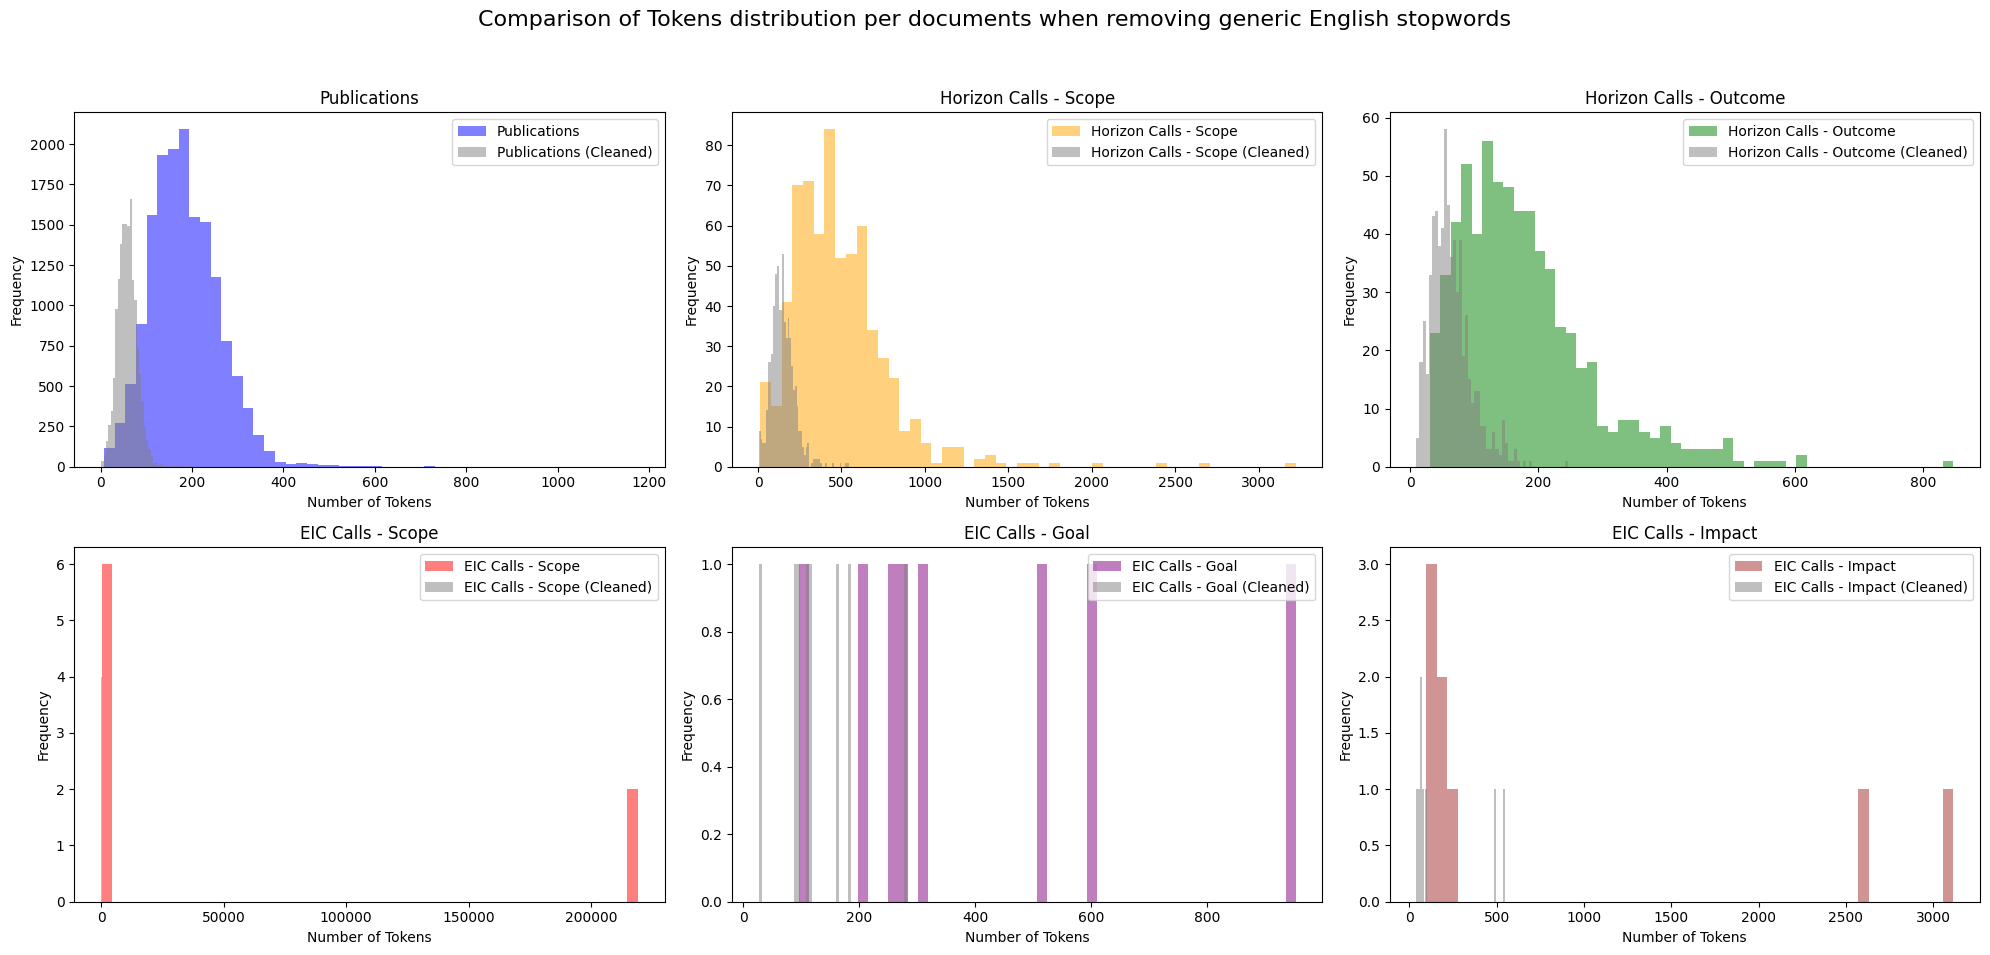

In [14]:
# Clear by frequency and with a generic list of stopwords

# Prepare list of stopwords
stop_words = stopwords.words('english')

tokenized_publications_clean, lengths_publications_clean = token_preprocess(tokenized_publications, stop_words) 

tokenized_calls_horizon_scope_clean, lengths_calls_scope_clean = token_preprocess(tokenized_calls_horizon_scope, stop_words)
tokenized_calls_horizon_outcome_clean, lengths_calls_outcome_clean = token_preprocess(tokenized_calls_horizon_outcome, stop_words)

tokenized_calls_eic_scope_clean, lengths_calls_eic_scope_clean = token_preprocess(tokenized_calls_eic_background_and_scope, stop_words)
tokenized_calls_eic_goal_clean, lengths_calls_eic_goal_clean = token_preprocess(tokenized_calls_eic_goal, stop_words)
tokenized_calls_eic_impact_clean, lengths_calls_eic_impact_clean= token_preprocess(tokenized_calls_eic_outcomes, stop_words)

# plot
title = 'Comparison of Tokens distribution per documents when removing generic English stopwords'

cleaned_tokens_lists = [lengths_publications_clean, lengths_calls_scope_clean, lengths_calls_outcome_clean,
                        lengths_calls_eic_scope_clean, lengths_calls_eic_goal_clean, lengths_calls_eic_impact_clean]
plot_token_comp(title, lengths, cleaned_tokens_lists)


In [23]:
# Clear by frequency and with a generic and customized list of stopwords

# load costumized stopwords
path = '/export/usuarios_ml4ds/mbalairon/topicmodeler/wordlists/horizon_stopwords.json'
with open(path, 'r') as file:
    data = json.load(file)

stopwords_customized = data.get('wordlist', []) 

# Prepare list of stopwords
stop_words = stopwords.words('english') + stopwords_customized

tokenized_publications_clean, lengths_publications_clean = token_preprocess(tokenized_publications, stop_words) 

tokenized_calls_horizon_scope_clean, lengths_calls_scope_clean = token_preprocess(tokenized_calls_horizon_scope, stop_words)
tokenized_calls_horizon_outcome_clean, lengths_calls_outcome_clean = token_preprocess(tokenized_calls_horizon_outcome, stop_words)

tokenized_calls_eic_scope_clean, lengths_calls_eic_scope_clean = token_preprocess(tokenized_calls_eic_background_and_scope, stop_words)
tokenized_calls_eic_goal_clean, lengths_calls_eic_goal_clean = token_preprocess(tokenized_calls_eic_goal, stop_words)
tokenized_calls_eic_impact_clean, lengths_calls_eic_impact_clean= token_preprocess(tokenized_calls_eic_outcomes, stop_words)

# plot
title = 'Comparison of Tokens distribution per documents when removing generic English and customized stopwords'

cleaned_tokens_lists = [lengths_publications_clean, lengths_calls_scope_clean, lengths_calls_outcome_clean,
                        lengths_calls_eic_scope_clean, lengths_calls_eic_goal_clean, lengths_calls_eic_impact_clean]
plot_token_comp(title, lengths, cleaned_tokens_lists)

NameError: name 'token' is not defined

In [181]:
# load a pretrained BERT model 
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

In [22]:
# obtain embeddings
df_publications['embeddings_BERT'] = df_publications['raw_text'].apply(lambda x: model.encode(x))

df_calls_horizon['scope_embeddings_BERT'] = df_calls_horizon['Scope_raw_text'].apply(lambda x: model.encode(x))
df_calls_horizon['outcome_embeddings_BERT'] = df_calls_horizon['Expected Outcome_raw_text'].apply(lambda x: model.encode(x))

df_calls_eic['scope_embeddings_BERT'] = df_calls_eic['Background and Scope_raw_text'].apply(lambda x: model.encode(x))
df_calls_eic['goal_embeddings_BERT'] = df_calls_eic['Overall Goal & Specific Objectives_raw_text'].apply(lambda x: model.encode(x))
df_calls_eic['impacts_embeddings_BERT'] = df_calls_eic['Expected Outcomes & Impacts_raw_text'].apply(lambda x: model.encode(x))

In [170]:
# create the corpus and the dictionary 

def get_dict(df ,col, stopwords=[]):
    '''
    claculate the dictionary of a given dataset 
    
    df -> Dataset
    col -> Column containing the lemmas
    stopwords -> List of stopwords
    '''
    
    # create corpus
    corpus = []
    for i in df.index:
        doc = df[col][i]
        corpus.append(doc.split()) 
    
    phrase_model = Phrases(corpus, min_count=2, threshold=20)
    corpus = [el for el in phrase_model[corpus]]
    
    # create dictionary 
    D = Dictionary(corpus)
    
    # clear extremes and stopwords
    D.filter_extremes(no_below=2, no_above=.5)
    stopword_ids = [D.token2id[word] for word in stopwords if word in D.token2id]
    D.filter_tokens(bad_ids=stopword_ids)


    return D

def get_tfidf_decomposition(df, col, stopwords):
    '''
    claculate the tf-idf decomposition of a given dataset
    
    df -> Dataset
    col -> Column containing the lemmas
    '''
    D = get_dict(df, col)
    vectorizer_tfidf = TfidfVectorizer(vocabulary=D.token2id)
    tf_idf = vectorizer_tfidf.fit_transform(df[col])
    return tf_idf.toarray().tolist()


def get_tfidf_matrix(df, col):
    '''
    claculate the tf-idf decomposition of a given dataset
    
    df -> Dataset
    col -> Column containing the lemmas
    '''
    D = get_dict(df, col)
    vectorizer_tfidf = TfidfVectorizer(vocabulary=D.token2id)
    tfidf_matrix = tfidf_vectorizer.fit_transform(data[column_name].astype(str))
    return tfidf_matrix


In [143]:
# prepare stopwords
stop_words = stopwords.words('english')
path = '/export/usuarios_ml4ds/mbalairon/topicmodeler/wordlists/horizon_stopwords.json'
with open(path, 'r') as file:
    data = json.load(file)

stopwords_customized = data.get('wordlist', []) 
stop_words = stopwords.words('english') + stopwords_customized


In [169]:
df_publications['tf-idf'] = get_tfidf_decomposition(df_publications, 'lemmas', stop_words)

df_calls_horizon['scope_tf-idf'] = get_tfidf_decomposition(df_calls_horizon, 'Scope_lemmas', stop_words)
df_calls_horizon['outcome_tf-idf'] = get_tfidf_decomposition(df_calls_horizon, 'Expected Outcome_lemmas', stop_words) 

df_calls_eic['scope_tf-idf'] = get_tfidf_decomposition(df_calls_eic, 'Background and Scope_lemmas', stop_words) 
df_calls_eic['goal_tf-idf'] = get_tfidf_decomposition(df_calls_eic, 'Overall Goal & Specific Objectives_lemmas', stop_words)
df_calls_eic['impact_tf-idf'] = get_tfidf_decomposition(df_calls_eic, 'Expected Outcomes & Impacts_lemmas', stop_words)

In [173]:
# Create a unique column for embeddings and tf-idf for the Horizon and EIC calls
#df_calls_horizon['embeddings'] = df_calls_horizon.apply(lambda row: row['scope_embeddings'] + row['outcome_embeddings'], axis=1)
#df_calls_horizon['embeddings_BERT'] = df_calls_horizon.apply(lambda row: row['scope_embeddings_BERT'] + row['outcome_embeddings_BERT'], axis=1)
df_calls_horizon['tf-idf'] = df_calls_horizon.apply(lambda row: row['scope_tf-idf'] + row['outcome_tf-idf'], axis=1)

#df_calls_eic['embeddings'] = df_calls_eic.apply(lambda row: row['scope_embeddings'] + row['goal_embeddings'] + row['impacts_embeddings'], axis=1)
#df_calls_eic['embeddings_BERT'] = df_calls_eic.apply(lambda row: row['scope_embeddings_BERT'] + row['goal_embeddings_BERT'] + row['impacts_embeddings_BERT'], axis=1)
df_calls_eic['tf-idf'] = df_calls_eic.apply(lambda row: row['scope_tf-idf'] + row['goal_tf-idf'] + row['impact_tf-idf'], axis=1)

## 3.1. Using word2vec embeddings

In [24]:
embeddings_publications = np.vstack(df_publications['embeddings'].to_list())
embeddings_calls = np.vstack(df_calls_horizon['embeddings'].to_list() + df_calls_eic['embeddings'].to_list()) # group together all the calls

# Normalize embeddings for cosine distance
embeddings_publications_normalized = normalize(embeddings_publications)
embeddings_calls_normalized = normalize(embeddings_calls)

# compute simmilarity matrix
cosine_sim_matrix = cosine_similarity(embeddings_publications_normalized, embeddings_calls_normalized)


In [25]:
cosine_sim_matrix.shape

(15710, 667)

In [28]:
print(cosine_sim_matrix)

[[0.94597511 0.95049522 0.96078061 ... 0.96475244 0.97623558 0.96729021]
 [0.95004888 0.95423393 0.96540139 ... 0.96800065 0.97948186 0.96953169]
 [0.98885129 0.99191452 0.99331864 ... 0.99342048 0.9952714  0.99425909]
 ...
 [0.96265143 0.96499776 0.97515127 ... 0.97774432 0.98662126 0.97833476]
 [0.92091403 0.92426606 0.91356808 ... 0.91704472 0.90715013 0.92504018]
 [0.99260834 0.99354794 0.98942168 ... 0.98989714 0.98427692 0.99205994]]


In [29]:
np.save('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/cosine_sim_matrix_we_doc2vec.npy', cosine_sim_matrix)

In [ ]:
# cosine_sim_matrix = np.load('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/cosine_sim_matrix_we_doc2vec.npy')


## 3.2. Using BERT embeddings 

In [30]:
embeddings_publications_BERT = np.vstack(df_publications['embeddings_BERT'].to_list())
embeddings_calls_BERT = np.vstack(df_calls_horizon['embeddings_BERT'].to_list() + df_calls_eic['embeddings_BERT'].to_list()) # group together all the calls

# Normalize embeddings for cosine distance
embeddings_publications_normalized_BERT = normalize(embeddings_publications_BERT)
embeddings_calls_normalized_BERT = normalize(embeddings_calls_BERT)

# compute simmilarity matrix
cosine_sim_matrix_BERT = cosine_similarity(embeddings_publications_normalized_BERT, embeddings_calls_normalized_BERT)

In [31]:
cosine_sim_matrix_BERT.shape

(15710, 667)

In [32]:
print(cosine_sim_matrix_BERT)

[[0.42927945 0.38466707 0.40106663 ... 0.4652568  0.5693389  0.656281  ]
 [0.388415   0.34767908 0.38809186 ... 0.48280948 0.39821297 0.5195178 ]
 [0.39532006 0.3754763  0.46131504 ... 0.4085586  0.38121185 0.4245754 ]
 ...
 [0.6093636  0.6111816  0.5539515  ... 0.65351486 0.7192081  0.69469297]
 [0.34931144 0.39908922 0.3026949  ... 0.4529777  0.33471978 0.41663438]
 [0.34502894 0.42258495 0.3462931  ... 0.32444263 0.32432213 0.37325603]]


In [33]:
np.save('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/cosine_sim_matrix_we_BERT.npy', cosine_sim_matrix_BERT)

## 3.3.  Using TF-IDF

In [176]:
tfidf_publications = np.vstack(df_publications['tf-idf'].to_list())
tfidf_calls = np.vstack(df_calls_horizon['tf-idf'].to_list()) # group together all the calls

# Normalize tf-idf for cosine distance
tfidf_publications_normalized = normalize(tfidf_publications)
tfidf_calls_normalized = normalize(tfidf_calls)

# compute simmilarity matrix
cosine_sim_matrix_tfidf = cosine_similarity(tfidf_publications_normalized, tfidf_calls_normalized)

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 47649 while Y.shape[1] == 13084

In [160]:
cosine_similarities.shape

(659, 15710)

In [ ]:
cosine_sim_matrix_tfidf.shape

In [ ]:
print(cosine_sim_matrix_BERT)

In [ ]:
np.save('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/cosine_sim_matrix_tfidf.npy', cosine_sim_matrix_tfidf)